In [304]:
import pandas as pd
import numpy as np
import yfinance as yf
from yahoo_fin import stock_info as y_fin
import json
import matplotlib.pyplot as plt
import datetime as dt
from dateutil.relativedelta import relativedelta

# Charting

In [305]:
def drawLine2P(x,y,xlims):
    xrange = np.arange(xlims[0],xlims[1],1)
    A = np.vstack([x, np.ones(len(x))]).T
    k, b = np.linalg.lstsq(A, y, rcond=None)[0]
    return [xrange, k*xrange + b]

In [306]:
def PlotTimeSeries(ticker, years_ago=5):#, months_ago=0):
    #closeHist = pd.DataFrame(FinDB[ticker]['stockHist']['Close']).rename({'Close':'Price'}, axis=1)
    try:
        closeHist = pd.DataFrame(yf.download(ticker,
                                             period='max', 
                                             progress=False)['Close']).rename({'Close':'Price'}, axis=1)
        #closeHist = pd.DataFrame(yf.Ticker(ticker).history(period='max')['Close']).rename({'Close':'Price'}, axis=1)
        closeHist.index = closeHist.index.to_pydatetime()
        closeHist.index.name = 'Date'
    except json.JSONDecodeError:
        closeHist = pd.DataFrame(y_fin.get_data(ticker)['close']).rename({'close':'Price'}, axis=1)
        closeHist.index = closeHist.index.to_pydatetime()
        closeHist.index.name = 'Date'
    closeHist = closeHist[closeHist.index > dt.datetime.now() + relativedelta(years=-years_ago)]
    closeHist.reset_index(inplace=True)
    closeHist['Month'] = closeHist.Date.apply(lambda x: dt.date(x.year, x.month, 1))
    closeHist = closeHist.groupby('Month').last().rename({'Price':'Price(Monthly avg.)'}, axis=1)
    closeHist['x_index'] = pd.Series(range(len(closeHist.index)), closeHist.index)
    
    # Find Peaks and Troughs 
    MinSeries = closeHist['Price(Monthly avg.)'][(closeHist['Price(Monthly avg.)'].shift(1) > closeHist['Price(Monthly avg.)']) & (closeHist['Price(Monthly avg.)'].shift(-1) > closeHist['Price(Monthly avg.)'])]
    MaxSeries = closeHist['Price(Monthly avg.)'][(closeHist['Price(Monthly avg.)'].shift(1) < closeHist['Price(Monthly avg.)']) & (closeHist['Price(Monthly avg.)'].shift(-1) < closeHist['Price(Monthly avg.)'])]
    BothSeries = pd.concat([MinSeries, MaxSeries]).sort_index()
    MaxMaxSeries = BothSeries[(BothSeries.shift(1) < BothSeries) & (BothSeries.shift(-1) < BothSeries)]
    MinMinSeries = BothSeries[(BothSeries.shift(1) > BothSeries) & (BothSeries.shift(-1) > BothSeries)]
    
    #3PTL Buy Line
    X = list()
    Y = list()
    x_1_date = MaxSeries.idxmax()
    x_1 = closeHist[closeHist.index==x_1_date].x_index.iloc[0]
    X.append(x_1)
    Y.append(MaxSeries.max())
    try:
        x_2_date = MaxSeries[MaxSeries.index > x_1_date].idxmax()
        x_2 = closeHist[closeHist.index==x_2_date].x_index.iloc[0]
        X.append(x_2)
        Y.append(MaxSeries[MaxSeries.index > x_1_date].max())
    except ValueError:
        pass
    #3PTL Sell Line
    X2 = list()
    Y2 = list()
    x2_1_date = MinSeries.idxmin()
    x2_1 = closeHist[closeHist.index==x2_1_date].x_index.iloc[0]
    X2.append(x2_1)
    Y2.append(MinSeries.min())
    try:
        x2_2_date = MinSeries[MinSeries.index > x2_1_date].idxmin()
        x2_2 = closeHist[closeHist.index==x2_2_date].x_index.iloc[0]
        X2.append(x2_2)
        Y2.append(MinSeries[MinSeries.index > x2_1_date].min())
    except ValueError:
        pass
    
    print('Current Price for', ticker, 'is', str(round(closeHist['Price(Monthly avg.)'].iloc[-1], 2)))
    
    plt.figure(figsize=[20,9])
    with plt.style.context('fivethirtyeight'):
        plt.plot(closeHist['Price(Monthly avg.)'], zorder=0)
        
        #Calculate and plot Sell line:
        if len(X2) < 2:
            pass
        else: 
            ThreePtS = drawLine2P(x=X2,y=Y2,xlims=[closeHist['x_index'].values.min(),
                                      closeHist['x_index'].values.max()+1])
            sellPrice = round(ThreePtS[1][-1], 2)
            if sellPrice < 0:
                sellPrice = round(0.00, 2)            
            print('Sell Price for', ticker, 'is', round(ThreePtS[1][-1], 2))
            plt.plot(closeHist.index, ThreePtS[1],
                     c='r', linestyle='dashed')
        
        #Calculate and plot Buy line:
        if len(X) < 2:
            pass
        else: 
            ThreePtB = drawLine2P(x=X,y=Y,xlims=[closeHist['x_index'].values.min(),
                                      closeHist['x_index'].values.max()+1])
            buyPrice = round(ThreePtB[1][-1], 2)
            if buyPrice < 0:
                buyPrice = round(0.00, 2)
            print('Buy Price for', ticker, 'is', buyPrice)
            plt.plot(closeHist.index, ThreePtB[1],
                     c='g', linestyle='dashed')

            
        plt.scatter(MinSeries.index, 
                    MinSeries,
                    c='r', s=50, zorder=10)
        plt.scatter(MaxSeries.index, 
                    MaxSeries,
                    c='g', s=50, zorder=10)
        plt.scatter(MaxMaxSeries.index, 
                    MaxMaxSeries,
                    c='y', s=100, zorder=5)
        plt.scatter(MinMinSeries.index, 
                    MinMinSeries,
                    c='y', s=100, zorder=5)
    plt.legend([closeHist.columns[0]])
    plt.autoscale()
    num = closeHist['Price(Monthly avg.)'].min()
    Y_lim_min = math.floor(num / 10 ** math.floor(math.log10(num))) * 10 ** math.floor(math.log10(num))
    num = closeHist['Price(Monthly avg.)'].max()
    Y_lim_max = math.ceil(num / 10 ** math.floor(math.log10(num))) * 10 ** math.floor(math.log10(num))
    plt.ylim(0, Y_lim_max)#,Y_lim_max)
    plt.show()

In [307]:
def Chart3PTL(tickerListing, years=5):
    List = tickerListing.split()
    for i in List:
        print(i)
        PlotTimeSeries(i, years)

In [313]:
np.linspace(0.1,1, 5)

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

Current Price for FMG.AX is 18.57
Sell Price for FMG.AX is 18.92


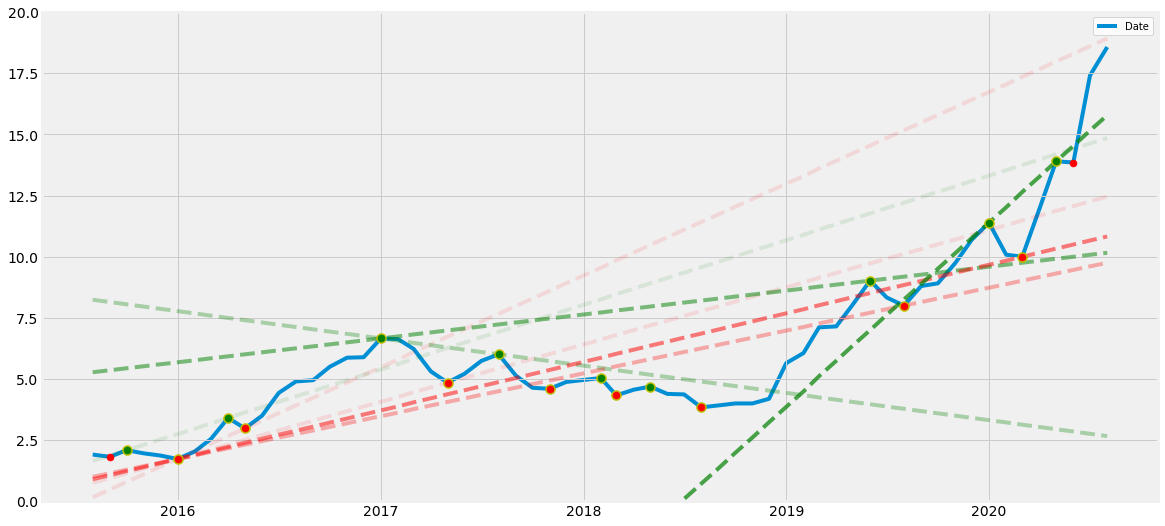

In [301]:
#closeHist = pd.DataFrame(FinDB[ticker]['stockHist']['Close']).rename({'Close':'Price'}, axis=1)
ticker = 'FMG.AX'
years_ago = 5

try:
    closeHist = pd.DataFrame(yf.download(ticker,
                                         period='max', 
                                         progress=False)['Close']).rename({'Close':'Price'}, axis=1)
    #closeHist = pd.DataFrame(yf.Ticker(ticker).history(period='max')['Close']).rename({'Close':'Price'}, axis=1)
    closeHist.index = closeHist.index.to_pydatetime()
    closeHist.index.name = 'Date'
except json.JSONDecodeError:
    closeHist = pd.DataFrame(y_fin.get_data(ticker)['close']).rename({'close':'Price'}, axis=1)
    closeHist.index = closeHist.index.to_pydatetime()
    closeHist.index.name = 'Date'
closeHist = closeHist[closeHist.index > dt.datetime.now() + relativedelta(years=-years_ago)]
closeHist.reset_index(inplace=True)
closeHist['Month'] = closeHist.Date.apply(lambda x: dt.date(x.year, x.month, 1))
closeHist = closeHist.groupby('Month').last().rename({'Price':'Price(Monthly avg.)'}, axis=1)
closeHist['x_index'] = pd.Series(range(len(closeHist.index)), closeHist.index)

# Find Peaks and Troughs 
MinSeries = closeHist['Price(Monthly avg.)'][(closeHist['Price(Monthly avg.)'].shift(1) > closeHist['Price(Monthly avg.)']) & (closeHist['Price(Monthly avg.)'].shift(-1) > closeHist['Price(Monthly avg.)'])]
MaxSeries = closeHist['Price(Monthly avg.)'][(closeHist['Price(Monthly avg.)'].shift(1) < closeHist['Price(Monthly avg.)']) & (closeHist['Price(Monthly avg.)'].shift(-1) < closeHist['Price(Monthly avg.)'])]
BothSeries = pd.concat([MinSeries, MaxSeries]).sort_index()
MaxMaxSeries = BothSeries[(BothSeries.shift(1) < BothSeries) & (BothSeries.shift(-1) < BothSeries)]
MinMinSeries = BothSeries[(BothSeries.shift(1) > BothSeries) & (BothSeries.shift(-1) > BothSeries)]

#3PTL Buy Line
X = list()
Y = list()
x_1_date = MaxSeries.idxmax()
x_1 = closeHist[closeHist.index==x_1_date].x_index.iloc[0]
X.append(x_1)
Y.append(MaxSeries.max())
try:
    x_2_date = MaxSeries[MaxSeries.index > x_1_date].idxmax()
    x_2 = closeHist[closeHist.index==x_2_date].x_index.iloc[0]
    X.append(x_2)
    Y.append(MaxSeries[MaxSeries.index > x_1_date].max())
except ValueError:
    pass
#3PTL Sell Line
X2 = list()
Y2 = list()
x2_1_date = MinSeries.idxmin()
x2_1 = closeHist[closeHist.index==x2_1_date].x_index.iloc[0]
X2.append(x2_1)
Y2.append(MinSeries.min())
try:
    x2_2_date = MinSeries[MinSeries.index > x2_1_date].idxmin()
    x2_2 = closeHist[closeHist.index==x2_2_date].x_index.iloc[0]
    X2.append(x2_2)
    Y2.append(MinSeries[MinSeries.index > x2_1_date].min())
except ValueError:
    pass

print('Current Price for', ticker, 'is', str(round(closeHist['Price(Monthly avg.)'].iloc[-1], 2)))

plt.figure(figsize=[20,9])
with plt.style.context('fivethirtyeight'):
    plt.plot(closeHist['Price(Monthly avg.)'], zorder=0)

    buyAlpha = 0.1
    sellAlpha = 0.1
    #Calculate and plot Sell line:
    if len(X2) < 2:
        pass
    else: 
        ThreePtS = drawLine2P(x=X2,y=Y2,xlims=[closeHist['x_index'].values.min(),
                                  closeHist['x_index'].values.max()+1])
        sellPrice = round(ThreePtS[1][-1], 2)
        if sellPrice < 0:
            sellPrice = round(0.00, 2)            
        print('Sell Price for', ticker, 'is', round(ThreePtS[1][-1], 2))
        plt.plot(closeHist.index, ThreePtS[1],
                 c='r', linestyle='dashed', alpha=sellAlpha)

    #Calculate and plot Buy line:
    if len(X) < 2:
        pass
    else: 
        ThreePtB = drawLine2P(x=X,y=Y,xlims=[closeHist['x_index'].values.min(),
                                  closeHist['x_index'].values.max()+1])
        buyPrice = round(ThreePtB[1][-1], 2)
        if buyPrice < 0:
            buyPrice = round(0.00, 2)
        print('Buy Price for', ticker, 'is', buyPrice)
        plt.plot(closeHist.index, ThreePtB[1],
                 c='g', linestyle='dashed', alpha=buyAlpha)

    
    Buy_Breach = closeHist.index[0]
    while Buy_Breach:
        # FIRST BUY ITERATION
        latestHist = closeHist.loc[Buy_Breach:]
        subSell = latestHist.index[latestHist['Price(Monthly avg.)'] < pd.Series(ThreePtS[1], closeHist.index).loc[Buy_Breach:]]
        if len(subSell) > 0:
            Sell_Breach = subSell[0]        
            preBreach = MaxSeries[MaxSeries.index < Sell_Breach].index
            postBreach = MaxSeries[MaxSeries.index > Sell_Breach].index
            if len(postBreach) > 0:
                pt_1 = closeHist.loc[closeHist.loc[preBreach]['Price(Monthly avg.)'].idxmax()]
                pt_2 = closeHist.loc[postBreach[0]]
                Y2 = [pt_1['Price(Monthly avg.)'], pt_2['Price(Monthly avg.)']]
                X2 = [pt_1['x_index'], pt_2['x_index']]
                ThreePtB = drawLine2P(x=X2,y=Y2,xlims=[closeHist['x_index'].values.min(),
                                                       closeHist['x_index'].values.max()+1])
                plt.plot(closeHist.index, ThreePtB[1],
                         c='g', linestyle='dashed', 
                         alpha=buyAlpha)
                buyAlpha+=0.2
            else:
                Sell_Breach = None
                break        
        else:
            Sell_Breach = None
            break
        while Sell_Breach:
            # FIRST SELL ITERATION
            latestHist = closeHist.loc[Sell_Breach:]
            superBuy = latestHist.index[latestHist['Price(Monthly avg.)'] > pd.Series(ThreePtB[1], closeHist.index).loc[Sell_Breach:]]
            if len(superBuy) > 0:
                Buy_Breach = superBuy[0]
                preBreach = MinSeries[MinSeries.index < Buy_Breach].index
                postBreach = MinSeries[MinSeries.index > Buy_Breach].index
                if len(postBreach) > 0:
                    pt_1 = closeHist.loc[closeHist.loc[preBreach]['Price(Monthly avg.)'].idxmin()]
                    pt_2 = closeHist.loc[postBreach[0]]
                    Y2 = [pt_1['Price(Monthly avg.)'], pt_2['Price(Monthly avg.)']]
                    X2 = [pt_1['x_index'], pt_2['x_index']]
                    ThreePtS = drawLine2P(x=X2,y=Y2,xlims=[closeHist['x_index'].values.min(),
                                                           closeHist['x_index'].values.max()+1])
                    plt.plot(closeHist.index, ThreePtS[1],
                             c='r', linestyle='dashed', 
                             alpha=sellAlpha)
                    sellAlpha+=0.2
                    break
                else:
                    Buy_Breach = None
                    break
            else:
                Buy_Breach = None
                break

    plt.scatter(MinSeries.index, 
                MinSeries,
                c='r', s=50, zorder=10)
    plt.scatter(MaxSeries.index, 
                MaxSeries,
                c='g', s=50, zorder=10)
    plt.scatter(MaxMaxSeries.index, 
                MaxMaxSeries,
                c='y', s=100, zorder=5)
    plt.scatter(MinMinSeries.index, 
                MinMinSeries,
                c='y', s=100, zorder=5)
plt.legend([closeHist.columns[0]])
plt.autoscale()
num = closeHist['Price(Monthly avg.)'].min()
Y_lim_min = math.floor(num / 10 ** math.floor(math.log10(num))) * 10 ** math.floor(math.log10(num))
num = closeHist['Price(Monthly avg.)'].max()
Y_lim_max = math.ceil(num / 10 ** math.floor(math.log10(num))) * 10 ** math.floor(math.log10(num))
plt.ylim(0, Y_lim_max)#,Y_lim_max)
plt.show()

FMG.AX
Current Price for FMG.AX is 18.57
Sell Price for FMG.AX is 18.92


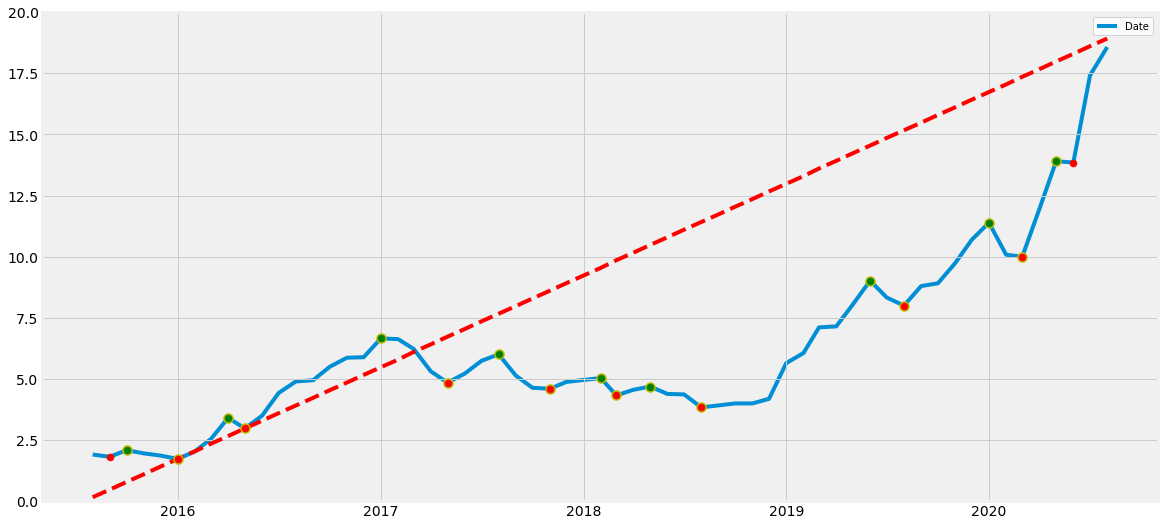

RMS.AX
Current Price for RMS.AX is 2.25
Sell Price for RMS.AX is 2.07


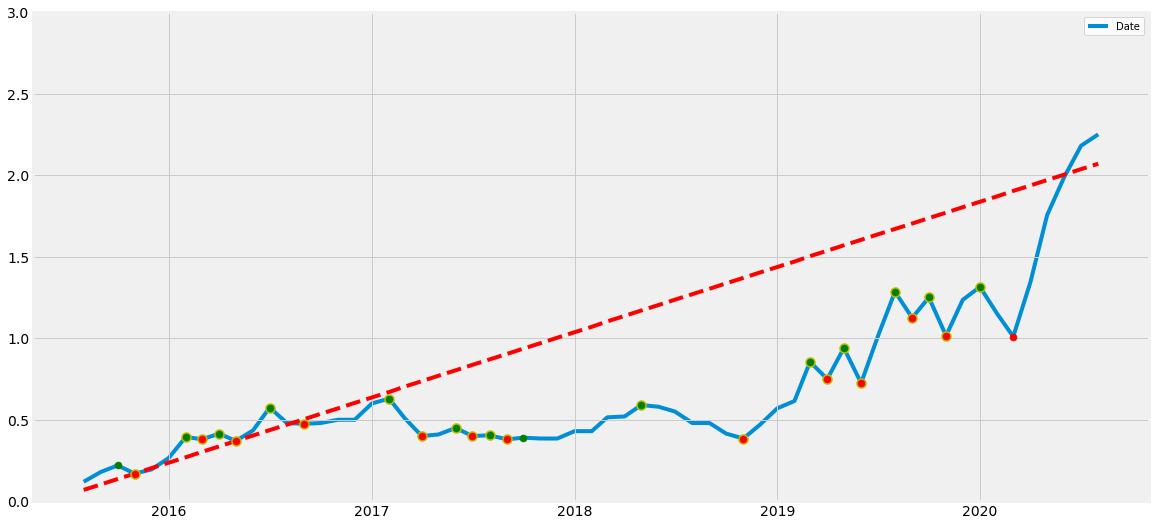

SFC.AX
Current Price for SFC.AX is 13.0
Sell Price for SFC.AX is 4.62
Buy Price for SFC.AX is 13.53


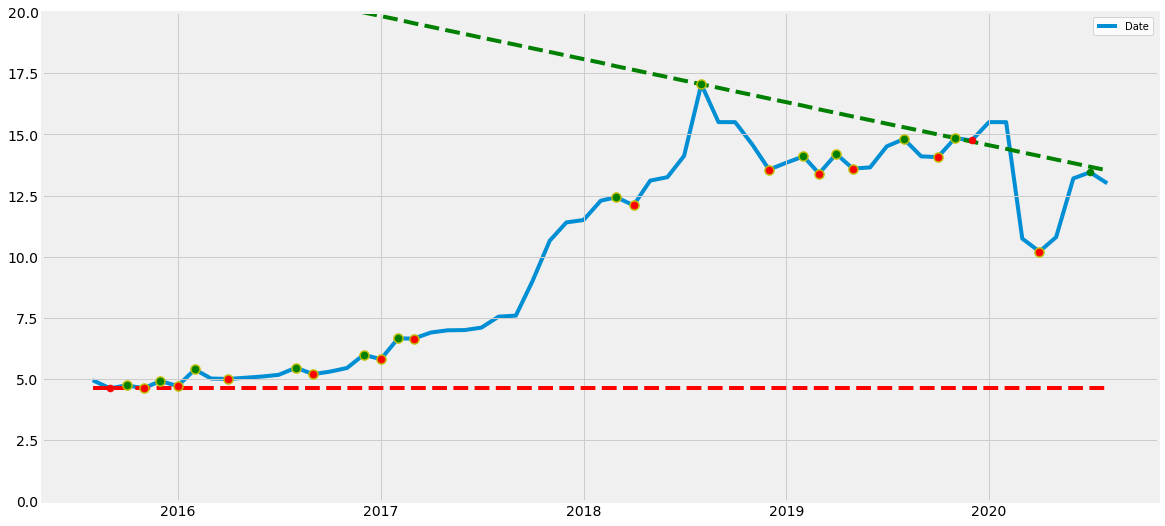

PRU.AX
Current Price for PRU.AX is 1.55
Sell Price for PRU.AX is 0.32


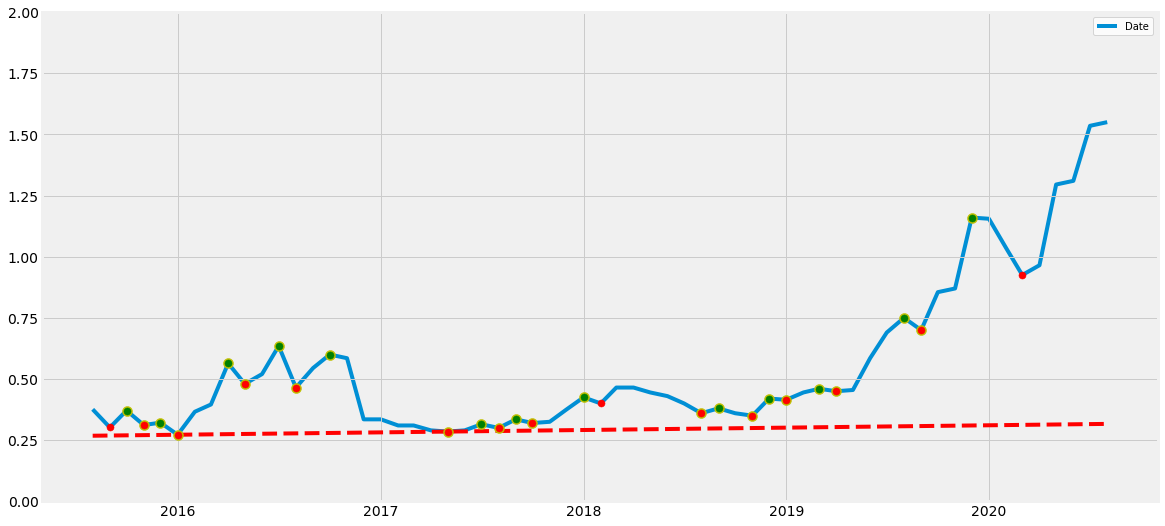

AQG.AX
Current Price for AQG.AX is 10.85
Sell Price for AQG.AX is 2.24
Buy Price for AQG.AX is 5.49


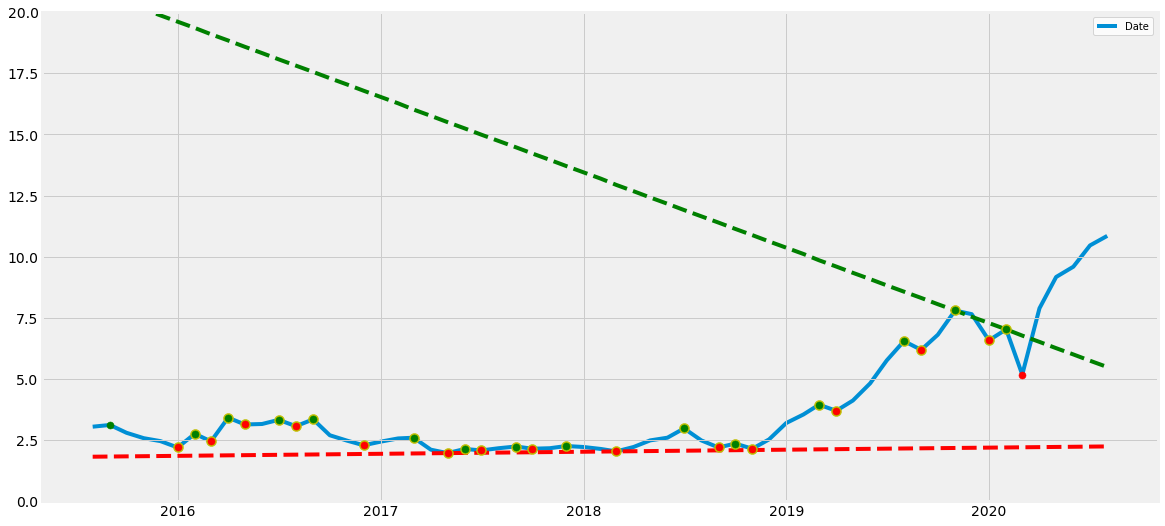

STO.AX
Current Price for STO.AX is 5.74
Sell Price for STO.AX is 3.48
Buy Price for STO.AX is 2.86


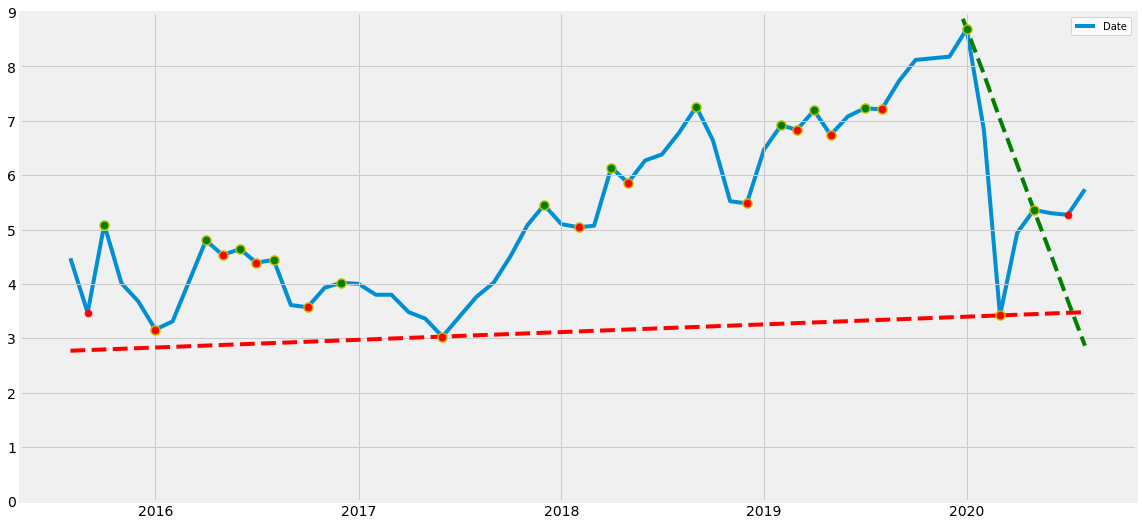

BFG.AX
Current Price for BFG.AX is 1.23
Sell Price for BFG.AX is 0.88


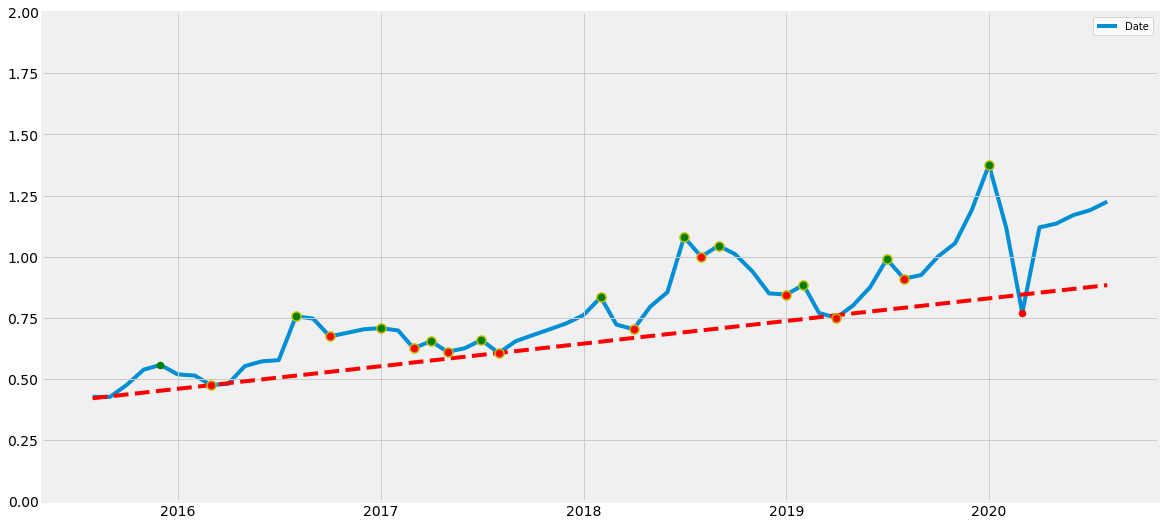

KOV.AX
Current Price for KOV.AX is 4.74
Sell Price for KOV.AX is 2.16
Buy Price for KOV.AX is 3.04


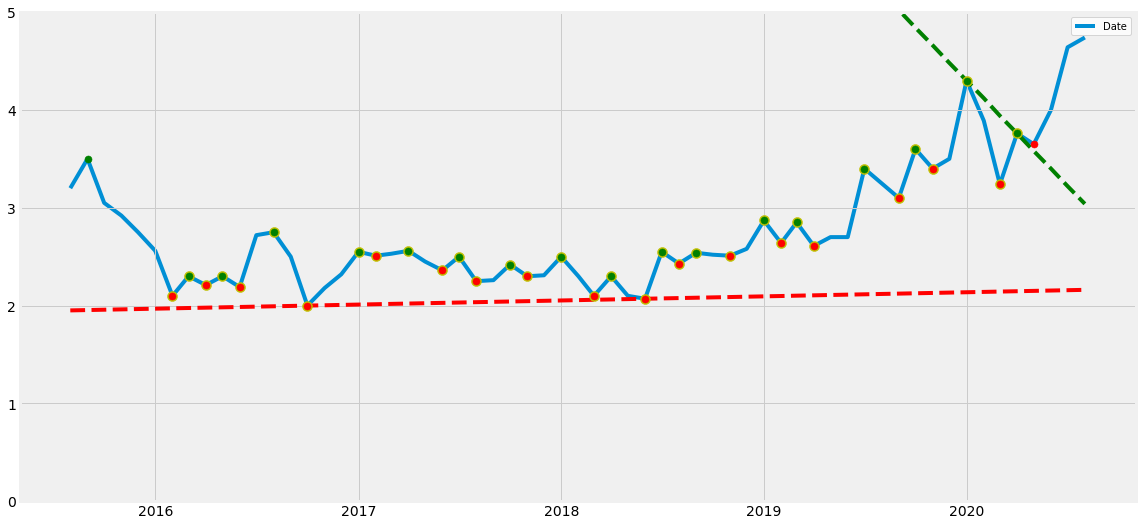

RRL.AX
Current Price for RRL.AX is 5.83
Sell Price for RRL.AX is 8.93
Buy Price for RRL.AX is 5.35


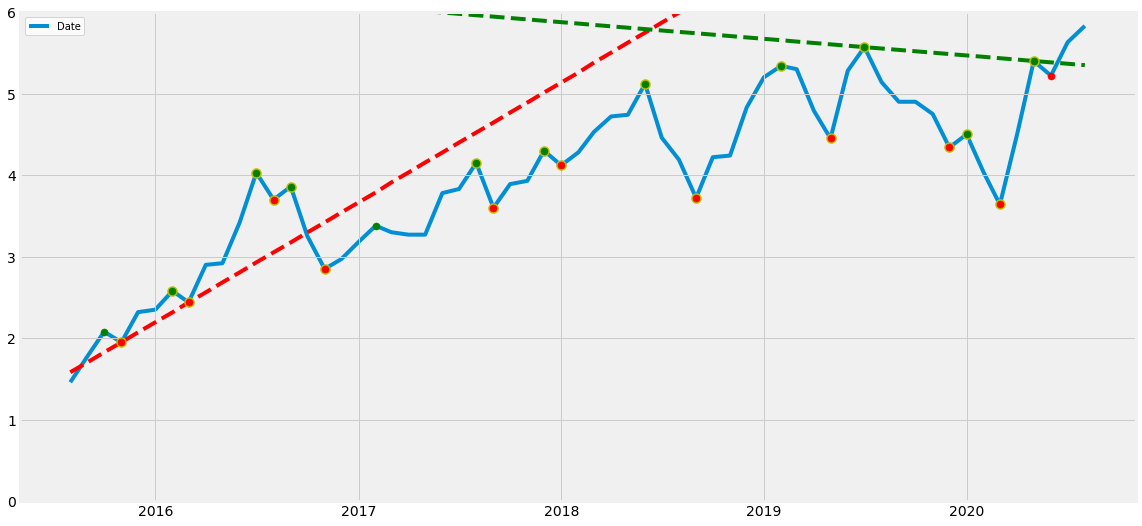

HAW.AX
Current Price for HAW.AX is 0.16
Sell Price for HAW.AX is 0.05


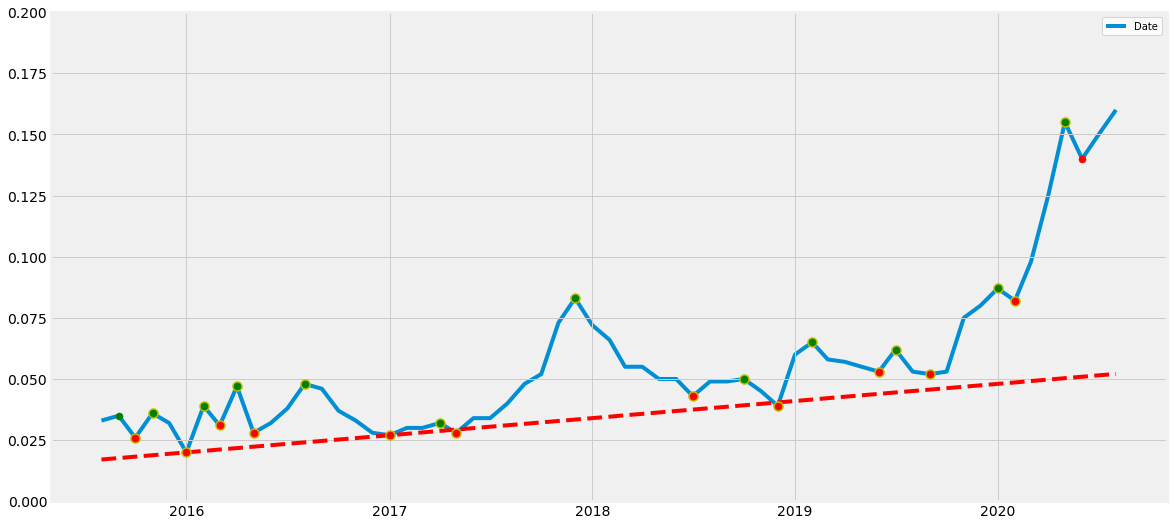

MRC.AX
Current Price for MRC.AX is 0.24
Sell Price for MRC.AX is 0.15
Buy Price for MRC.AX is 0.28


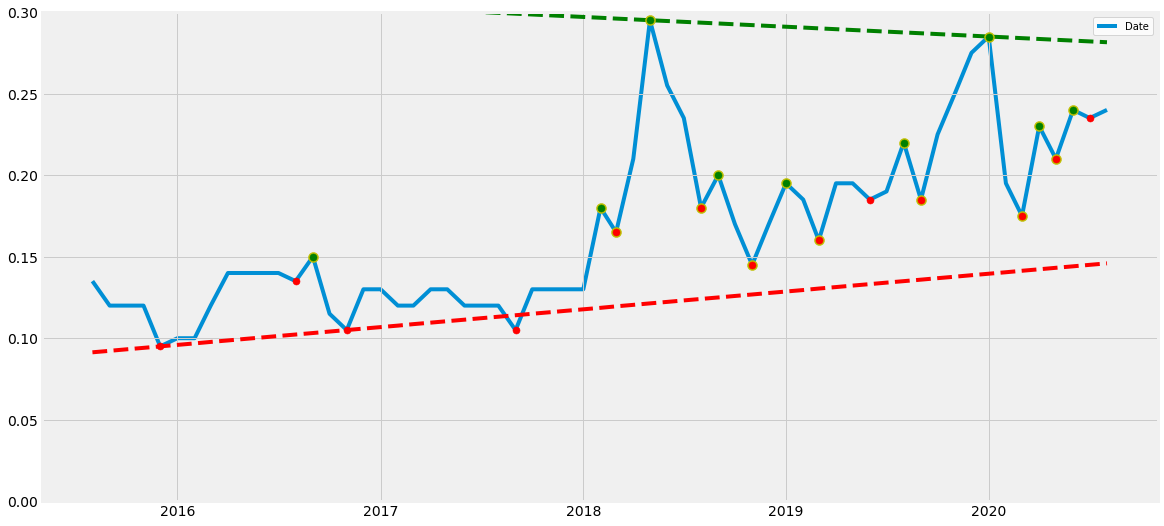

KRM.AX
Current Price for KRM.AX is 0.04
Buy Price for KRM.AX is 0.0


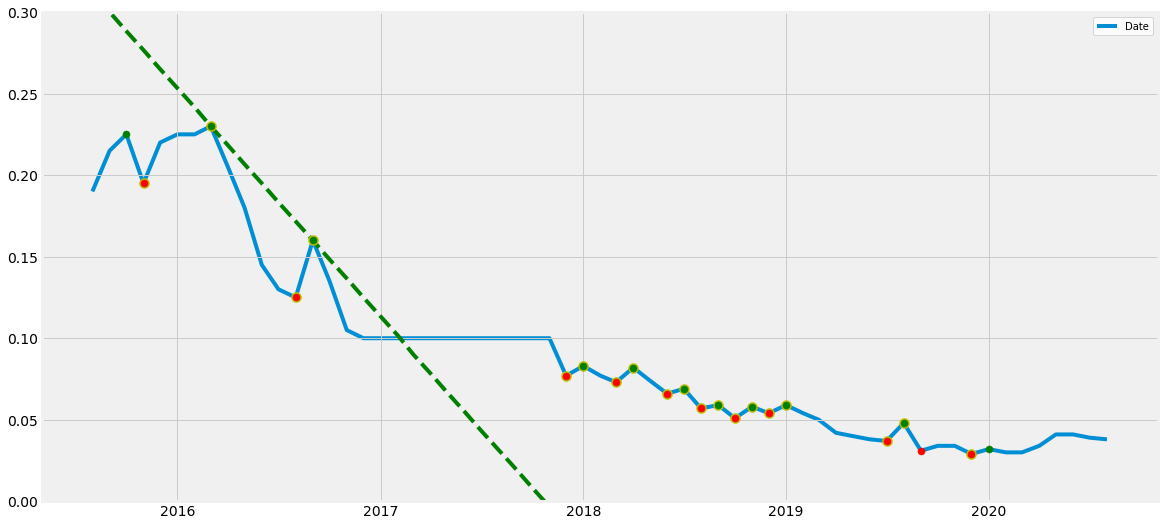

GEAR.AX
Current Price for GEAR.AX is 18.08
Sell Price for GEAR.AX is 18.46
Buy Price for GEAR.AX is 13.08


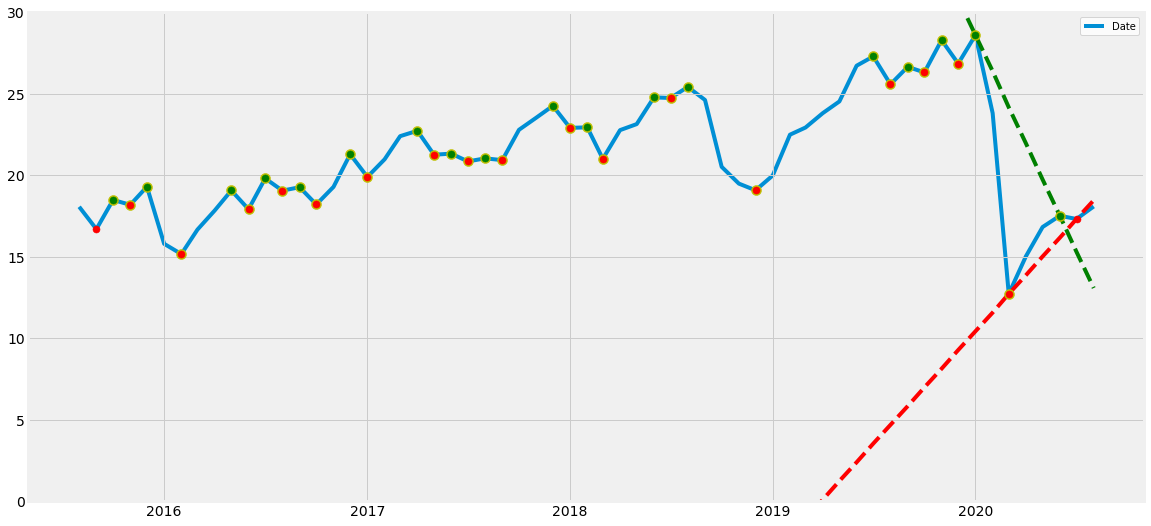

AGD.AX
Current Price for AGD.AX is 0.2
Sell Price for AGD.AX is 0.07
Buy Price for AGD.AX is 0.16


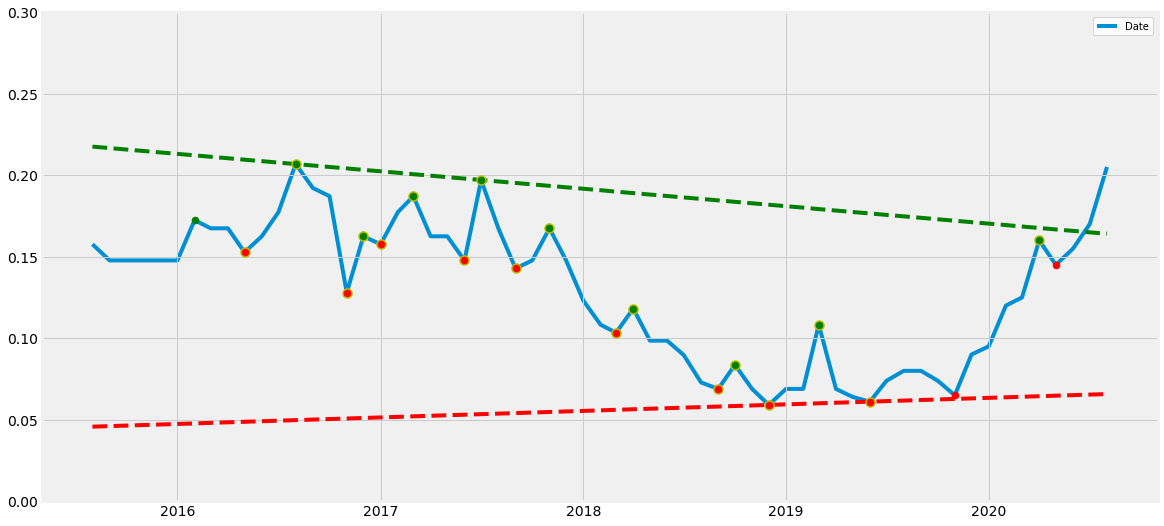

MML.AX
Current Price for MML.AX is 0.97
Sell Price for MML.AX is 0.41
Buy Price for MML.AX is 0.65


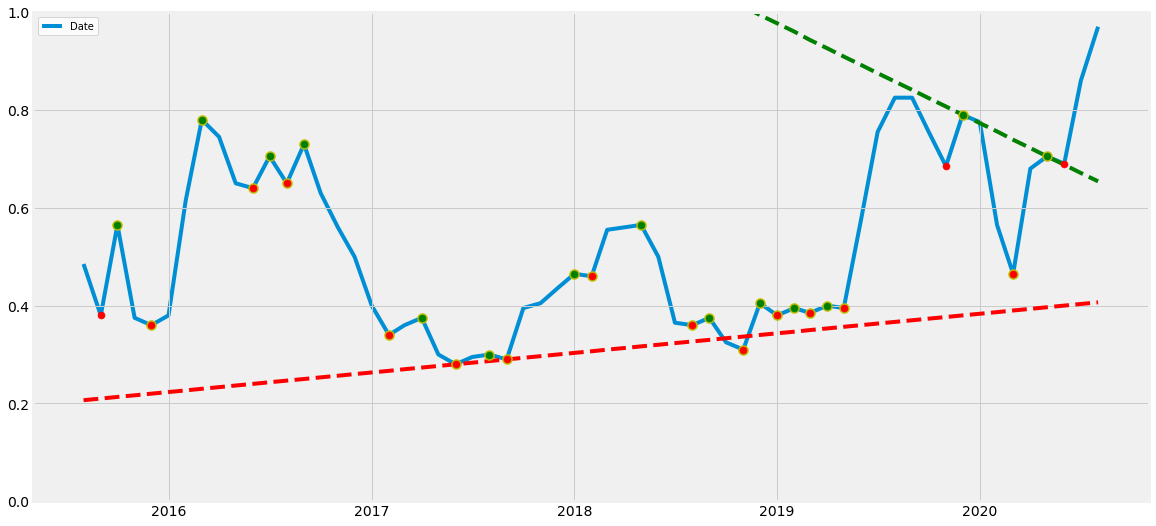

In [308]:
Chart3PTL("""FMG.AX
RMS.AX
SFC.AX
PRU.AX
AQG.AX
STO.AX
BFG.AX
KOV.AX
RRL.AX
HAW.AX
MRC.AX
KRM.AX
GEAR.AX
AGD.AX
MML.AX""")